Nama : Ahmad Sholihin

Email : asholeeqeen41@gmail.com

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadsholihin","key":"116ae1296508ab7ce5ccbff7971d5049"}'}

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!ls

 94% 113M/121M [00:04<00:00, 25.4MB/s]
100% 121M/121M [00:04<00:00, 27.0MB/s]
'archive (1).zip'			   kaggle.json
 face-expression-recognition-dataset.zip   sample_data


In [7]:
#Import Library
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model,Sequential
from keras.optimizers import Adam

In [9]:
# Ekstraksi pada file zip sebelumnya
local_zip = '/content/face-expression-recognition-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [18]:
#Delete beberapa folder train yang tidak dibutuhkan
!rm -rf '/content/images/train/angry'
!rm -rf '/content/images/train/neutral'
!rm -rf '/content/images/train/disgust'
!rm -rf '/content/images/train/fear'
!rm -rf '/content/images/train/surprise'

#Delete beberapa folder validation yang tidak dibutuhkan
!rm -rf '/content/images/validation/angry'
!rm -rf '/content/images/validation/neutral'
!rm -rf '/content/images/validation/disgust'
!rm -rf '/content/images/validation/fear'
!rm -rf '/content/images/validation/surprise'

In [19]:
train_folder = '/content/images/train'
validation_folder = '/content/images/validation'

In [20]:
#Augmentasi dan generate gambar
train_datagen = ImageDataGenerator(rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [21]:
#Preprocessing data with generator
train_generator = train_datagen.flow_from_directory(
        train_folder,  
        target_size=(48, 48), 
        batch_size=8,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_folder, 
        target_size=(48, 48),  
        batch_size=8, 
        class_mode='binary')

Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


In [22]:
#CNN Architecture Model sequentials (Maxpooling and convolutional layer), flatten to make single array
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Sequential Model
model = Sequential()

# Conv 1
model.add(Conv2D(64,(3,3), input_shape=(48, 48,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 2
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 3
model.add(Conv2D(256,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 4
model.add(Conv2D(512,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(1024))
model.add(Activation('relu'))

# Fully connected layer 2
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
#Callback untuk mencegah overfitting dengan menghentikan training, apabila telah terpenuhi
class reduceOverfitting(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93 ):
      print("\nStopped! Akurasi training dan validasi sudah mencapai 93% dan 93%")
      self.model.stop_training = True
stop = reduceOverfitting()

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        1792      
_________________________________________________________________
activation_12 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
activation_13 (Activation)   (None, 21, 21, 128)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)        

In [25]:
trainmodel = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_generator.n//validation_generator.batch_size,
    verbose =2,       
      callbacks=[stop] 
)

Epoch 1/30
1512/1512 - 242s - loss: 0.6544 - accuracy: 0.6178 - val_loss: 0.5621 - val_accuracy: 0.7345
Epoch 2/30
1512/1512 - 240s - loss: 0.4813 - accuracy: 0.7638 - val_loss: 0.4158 - val_accuracy: 0.8105
Epoch 3/30
1512/1512 - 242s - loss: 0.3988 - accuracy: 0.8155 - val_loss: 0.3488 - val_accuracy: 0.8419
Epoch 4/30
1512/1512 - 243s - loss: 0.3500 - accuracy: 0.8403 - val_loss: 0.3469 - val_accuracy: 0.8361
Epoch 5/30
1512/1512 - 244s - loss: 0.3249 - accuracy: 0.8544 - val_loss: 0.3188 - val_accuracy: 0.8547
Epoch 6/30
1512/1512 - 243s - loss: 0.2983 - accuracy: 0.8688 - val_loss: 0.3121 - val_accuracy: 0.8622
Epoch 7/30
1512/1512 - 242s - loss: 0.2819 - accuracy: 0.8776 - val_loss: 0.2743 - val_accuracy: 0.8770
Epoch 8/30
1512/1512 - 243s - loss: 0.2697 - accuracy: 0.8832 - val_loss: 0.3049 - val_accuracy: 0.8736
Epoch 9/30
1512/1512 - 246s - loss: 0.2528 - accuracy: 0.8933 - val_loss: 0.2762 - val_accuracy: 0.8804
Epoch 10/30
1512/1512 - 244s - loss: 0.2395 - accuracy: 0.8976 -

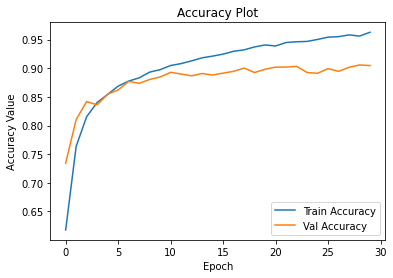

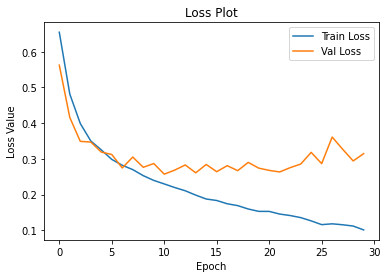

In [27]:
#Accuracy Plot
plt.plot(trainmodel.history['accuracy'], label='Train Accuracy')
plt.plot(trainmodel.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch') 
plt.legend(loc="lower right")
plt.show()

#Loss Plot
plt.plot(trainmodel.history['loss'], label='Train Loss')
plt.plot(trainmodel.history['val_loss'], label='Val Loss')
plt.title('Loss Plot')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()